In [1]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
from tensorflow.keras.layers import Attention
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
!pip install datasets
from datasets import load_dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
news_data = load_dataset('cnn_dailymail', '3.0.0')
news_data

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [4]:
train_news_data = pd.DataFrame(news_data['train'])
train_news_data

,article,highlights,id
0,"LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell...",Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .\nYoung actor says he has no plans to fritter his cash away .\nRadcliffe's earnings from first five Potter films have be...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,"Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a ja...","Mentally ill inmates in Miami are housed on the ""forgotten floor""\nJudge Steven Leifman says most are there as a result of ""avoidable felonies""\nWhile CNN tours facility, patient shouts: ""I am the...",ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who were on the Minneapolis bridge when it collapsed told harrowing tales of survival. ""The whole bridge from one side of the Mississippi to the other just ...","NEW: ""I thought I was going to die,"" driver says .\nMan says pickup truck was folded in half; he just has cut on face .\nDriver: ""I probably had a 30-, 35-foot free fall""\nMinnesota bridge collaps...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,"WASHINGTON (CNN) -- Doctors removed five small polyps from President Bush's colon on Saturday, and ""none appeared worrisome,"" a White House spokesman said. The polyps were removed and sent to the ...","Five small polyps found during procedure; ""none worrisome,"" spokesman says .\nPresident reclaims powers transferred to vice president .\nBush undergoes routine colonoscopy at Camp David .",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,"(CNN) -- The National Football League has indefinitely suspended Atlanta Falcons quarterback Michael Vick without pay, officials with the league said Friday. NFL star Michael Vick is set to appea...","NEW: NFL chief, Atlanta Falcons owner critical of Michael Vick's conduct .\nNFL suspends Falcons quarterback indefinitely without pay .\nVick admits funding dogfighting operation but says he did n...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a
...,...,...,...
287108,"The nine-year-old daughter of a black, unarmed man shot dead by a white Phoenix police officer who mistook a pill bottle for a gun is speaking out in an emotional interview. Rumain Brisbon, 34, w...","Rumain Brisbon, 34, was killed after Phoenix police say an officer feared the suspect was armed during a struggle .\nHe was thought to be selling drugs and after fleeing from officers, a cop misto...",279a12d3ee37b8109cc192a9e88115a5a631fb06
287109,"Legalising assisted suicide is a slippery slope toward widespread killing of the sick, MPs and peers were told yesterday. A former euthanasia supporter warned of a surge in deaths if Parliament al...","Theo Boer, a European assisted suicide watchdog, said 'don't do it'\nIn Netherlands euthanasia has been legal since 2002 .\nHowever, in six years the numbers of deaths have doubled .\nPeers are pr...",b5bc9d404a9a5d890c9fc26550b67e6d8d83241f
287110,A group calling itself 'The Women of the 99 Percent' is making robocalls across the United States in an attempt to link Republican members of the House of Representatives to 'the war on women led ...,Ohio congressman criticised for 'condoning the war on women led by Rush Limbaugh'\nMessages left by mysterious unregistered group .,500862586f925e406f8b662934e1a71bbee32463
287111,Most men enjoy a good pint of lager or real ale while they are watching football or relaxing with friends. Very few would dedicate themselves for more than two decades to the world's longest pub c...,"The Black Country Ale Tairsters have been to 16,337 pubs, hotels and wine bars .\nThey fill in an elaborate score card and leave a personalised beer mat in every bar .\nWomen are allowed to the pu...",32a1f9e5c37a938c0c0bca1a1559247b9c4

In [5]:
test_news_data = pd.DataFrame(news_data['test'])
test_news_data

,article,highlights,id
0,"(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian terr...","Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June .\nIsrael and the United States opposed the move, which could open the door to war cr...",f001ec5c4704938247d27a44948eebb37ae98d01
1,"(CNN)Never mind cats having nine lives. A stray pooch in Washington State has used up at least three of her own after being hit by a car, apparently whacked on the head with a hammer in a misguide...","Theia, a bully breed mix, was apparently hit by a car, whacked with a hammer and buried in a field .\n""She's a true miracle dog and she deserves a good life,"" says Sara Mellado, who is looking for...",230c522854991d053fe98a718b1defa077a8efef
2,"(CNN)If you've been following the news lately, there are certain things you doubtless know about Mohammad Javad Zarif. He is, of course, the Iranian foreign minister. He has been U.S. Secretary of...",Mohammad Javad Zarif has spent more time with John Kerry than any other foreign minister .\nHe once participated in a takeover of the Iranian Consulate in San Francisco .\nThe Iranian foreign mini...,4495ba8f3a340d97a9df1476f8a35502bcce1f69
3,"(CNN)Five Americans who were monitored for three weeks at an Omaha, Nebraska, hospital after being exposed to Ebola in West Africa have been released, a Nebraska Medicine spokesman said in an emai...",17 Americans were exposed to the Ebola virus while in Sierra Leone in March .\nAnother person was diagnosed with the disease and taken to hospital in Maryland .\nNational Institutes of Health says...,a38e72fed88684ec8d60dd5856282e999dc8c0ca
4,"(CNN)A Duke student has admitted to hanging a noose made of rope from a tree near a student union, university officials said Thursday. The prestigious private school didn't identify the student, c...","Student is no longer on Duke University campus and will face disciplinary review .\nSchool officials identified student during investigation and the person admitted to hanging the noose, Duke says...",c27cf1b136cc270023de959e7ab24638021bc43f
...,...,...,...
11485,Telecom watchdogs are to stop a rip-off that allows mobile phone firms to charge customers to call supposedly free 0800 numbers. Currently mobile phone companies charge customers up to 20p a minut...,Operators are charging up to 20p a minute - even if 0800 numbers are free .\nSome are important services run by Government and NHS departments .\nWatchdog Ofcom published proposals to put an end t...,0ac776a4dc09ca97c136f4314fed4defb48a361a
11486,The chilling reenactment of how executions are carried out in Indonesia which was broadcast to millions of viewers is set to become a brutal reality for Andrew Chan and Myruan Sukumaran. Time has ...,Bali Nine ringleaders will face the firing squad at midnight on Tuesday .\nAndrew Chan and Myruan Sukumaran have requested their last wishes .\nThe men will likely be executed at a place called Ni...,fe89a6a2e28d173e5ad4c6d814c15b95aa969e3f
11487,It is a week which has seen him in deep water - both on and off the pitch. Just days after Dallas Cowboys' Greg Hardy was suspended from 10 NFL games he appeared to get into trouble when he drove ...,Hardy was convicted of domestic abuse against ex-girlfriend Nicki Holder and was suspended from the Dallas Cowboys for 10 days by the NFL .\nCharges were eventually dropped after Holder could not ...,ded2f535cd6ab95d11b5f4ea29bbf2b2d3c55c50
11488,"Despite the hype surrounding its first watch, the iPhone is still the engine behind Apple's phenomenal success, its latest figures have revealed. The results far surpassed most analysts' expectati...","Apple sold more than 61 million iPhones in the quarter .\nApple didn't report any results for the new Apple Watch .\nBelieved around 2 million watches have been sold, according t

In [6]:
validation_news_data = pd.DataFrame(news_data['validation'])
validation_news_data

,article,highlights,id
0,"(CNN)Share, and your gift will be multiplied. That may sound like an esoteric adage, but when Zully Broussard selflessly decided to give one of her kidneys to a stranger, her generosity paired up ...",Zully Broussard decided to give a kidney to a stranger .\nA new computer program helped her donation spur transplants for six kidney patients .,a4942dd663020ca54575471657a0af38d82897d6
1,"(CNN)On the 6th of April 1996, San Jose Clash and DC United strode out in front of 31,683 expectant fans at the Spartan Stadium in San Jose, California. The historic occasion was the first ever Ma...",The 20th MLS season begins this weekend .\nLeague has changed dramatically since its inception in 1996 .\nSome question whether rules regarding salary caps and transfers need to change .,4157bc4da185971e2742f349d69a037343bc0d95
2,"(CNN)French striker Bafetimbi Gomis, who has a history of fainting, said he is now ""feeling well"" after collapsing during Swansea's 3-2 loss at Tottenham in the Premier League on Wednesday. The wo...","Bafetimbi Gomis collapses within 10 minutes of kickoff at Tottenham .\nBut he reportedly left the pitch conscious and wearing an oxygen mask .\nGomis later said that he was ""feeling well""\nThe inc...",60736693e3b1b32d14337a317190c6606e879a85
3,(CNN)It was an act of frustration perhaps more commonly associated with golf's fictional anti-hero Happy Gilmore than the world's reigning No 1. player. But when Rory McIlroy pulled his second sho...,Rory McIlroy throws club into water at WGC Cadillac Championship .\nNorthern Irishman frustrated after pulling shot into water hazard .,8cdf9cc3ed0276b7a7944cc18ba459355b5984ad
4,(CNN)A Pennsylvania community is pulling together to search for an eighth-grade student who has been missing since Wednesday. The search has drawn hundreds of volunteers on foot and online. The pa...,"Cayman Naib, 13, hasn't been heard from since Wednesday .\nPolice, family, volunteers search for eighth-grader .",2e6613d531843515bf5401286cc3e45c4df530d2
...,...,...,...
13363,"It is the dream of many young children, the chance to be sheriff of their very own Wild West town. And it seems wannabe cowboys can make that dream come true after an entire Wild West town went up...","The town in Valley Center, San Diego, has been used for advertising and movies and is now up for grabs .\nThe buildings - including a blacksmiths, a barbershop and a print shop - have been furnish...",5ab020397649fecae34c9e3ac2f7a6c67a5f3153
13364,"It’s the type of encounter that can send panic through a herd, but this fearless impala refused to turn and run after a crocodile popped out of the water in front of it. At one point the predator’...",Photographer Graham Hewer captured the jaw-dropping scene at Kruger National Park in South Africa .\nThe impala didn't turn and run after the crocodile popped out of the water and came within inch...,b189166be7b1dc93f635d7860d4978498608ae07
13365,A group of tourists to the Bahamas enjoyed one of the country’s unique attractions when they were greeted on a boat by a herd of swimming pigs looking for a snack. An amusing video shows the pigs ...,The pigs swim through the crystal clear sea and tread water by the boat .\nVideo shows pigs jumping onto the side of the boat and begging for food .\nOnce fed the animals jump down and head toward...,c513500c9c53726b4ed0065b32bbca651c64b368
13366,Pippa Middleton bundled up against the London wind today in an icy blue bloke coat accessorised with smart glasses and her favourite Milli Millu handbag. The brunette is back in London following n...,Kate's sister is back in London following 'cringeworthy' U.S TV debut .\nUS TV company NBC has decided not to hire her as 'special correspondent'\nSet to become an aunt for the second time next mo...,cf2450f9e17d98ff9065c88262cba77855092d84


In [7]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [82]:
def article_cleaner(article):

    newString = article
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'[:‘’<>.,_"\;%|+&=*%!?#$@/]', '',  newString)
    newString = re.sub('\xa0', ' ',  newString)
    newString = re.sub('\n', ' ',  newString)
    newString = re.sub('https:', '', newString)
    newString = re.sub('href', '', newString)

    news_sent = []

    for i in newString.split():
      try:
        re.compile('\'').match(i).start() == 0
        i = i[1:].lower()
        if i in list(contraction_mapping.keys()):
          i = contraction_mapping[i]
          news_sent.append(i)
        else:
          news_sent.append(i)
      except:
        if i.lower() in list(contraction_mapping.keys()):
          i = contraction_mapping[i.lower()]
          news_sent.append(i)
        else:
          news_sent.append(i)

    newString = ' '.join(news_sent)

    newString = re.sub('\'()',' ', newString)
    
    try:
      indx = [_.start() for _ in re.finditer('EST', newString)]
      newString = newString[indx[1] + 4:]
      indx1 = newString.find('.')
      newString = newString[indx1 + 1:]
    except:
      newString = newString

    try:
      indx = [_.start() for _ in re.finditer('--', newString)]
      newString = newString[indx[0] + 2:]
    except:
      newString = newString

    try:
      indx1 = newString.find('E-mail to a friend')
      newString = newString[:indx1]
    except:
      newString = newString

    # try:
    #   indx1 = newString.find('CNN)')
    #   newString = newString[indx1+4:]
    # except:
    #   newString = newString

    newString = newString.lower()
    newString = re.sub(r'-',' ', newString)

    tokens = [word for word in newString.split() if word not in stop_words]

    long_words = []

    for word in tokens:
        if len(word) >= 3:                  #removing short word
            long_words.append(word) 

    return (" ".join(long_words)).strip()

In [83]:
cleaned_article_train = []

for art in list(train_news_data['article'][:1000]):
    cleaned_article_train.append(article_cleaner(art))

clean_article_train = pd.DataFrame(cleaned_article_train)
clean_article_train.columns = ['article']
clean_article_train

,article
0,harry potter star daniel radcliffe gains access reported £20 million (411 million) fortune turns monday insists money cast spell daniel radcliffe harry potter harry potter order phoenix disappoint...
1,ninth floor miami dade pretrial detention facility dubbed forgotten floor inmates severe mental illnesses incarcerated ready appear court often face drug charges charges assaulting officer charges...
2,drivers minneapolis bridge collapsed told harrowing tales survival whole bridge one side mississippi completely gave way fell way survivor gary babineau told cnn probably foot free fall cars water...
3,doctors removed five small polyps president bush colon saturday none appeared worrisome white house spokesman said polyps removed sent national naval medical center bethesda maryland routine micro...
4,national football league indefinitely suspended atlanta falcons quarterback michael vick without pay officials league said friday nfl star michael vick set appear court monday judge final say plea...
...,...
995,mother murdered schoolboy damilola taylor died suspected heart attack press association reported wednesday gloria taylor outside london central criminal court damilola older brother tunde 2006 glo...
996,smiling pope benedict xvi arrived united states tuesday afternoon start six day two city journey take white house halls united nations papal plane shepherd touched andrews air force base maryland ...
997,eight florida teenagers six girls tried adults could sentenced life prison alleged roles videotaped beating another teen state attorney office said thursday teenagers seen video assaulting year ol...
998,following excerpts heather mills paul mccartney divorce ruling issued honorable justice bennett dollar figures based current exchange rate approximately two dollars per british pound heather mills...


In [84]:
cleaned_article_test = []

for article in test_news_data['article'][0:200]:
    cleaned_article_test.append(article_cleaner(article))

clean_article_test = pd.DataFrame(cleaned_article_test)
clean_article_test.columns = ['article']
clean_article_test

,article
0,(cnn)the palestinian authority officially became 123rd member international criminal court wednesday step gives court jurisdiction alleged crimes palestinian territories formal accession marked ce...
1,survive according washington state university dog friendly white black bully breed mix named theia receiving care veterinary teaching hospital four days apparent death dog managed stagger nearby f...
2,details worked coming weeks received hero welcome arrived iran sunny friday morning long live zarif crowds chanted car rolled slowly packed street may well read polished unusually one burdened wei...
3,(cnn)five americans monitored three weeks omaha nebraska hospital exposed ebola west africa released nebraska medicine spokesman said email wednesday one five heart related issue saturday discharg...
4,(cnn)a duke student admitted hanging noose made rope tree near student union university officials said thursday prestigious private school identify student citing federal privacy laws news release...
...,...
195,tax revolt could averted free online filing sponsor eager provide filling 1040s part made income tax odious masses long time remember parents fretting shoeboxes receipts sometime april cruelest mo...
196,senselessness loss life yarmouk camp outskirts damascus set refugee camp palestinians 1950s slowly evolved neighborhood years since 2012 engulfed syrian conflict two weeks ago isis fighters storme...
197,every latina man cheats schumer joked awful kinda mtv immediately cut jlo laughing like ummm accurate response vin diesel sings furious paul walker tribute song mtv movie awards shailene woodley s...
198,(cnn)for superhero fans cup runneth know members avengers iron man captain america hulk rest fact like quicksilver joining cast avengers age ultron sequel one character remained mystery vision pla...


In [85]:
cleaned_article_validation = []

for article in validation_news_data['article'][0:1000]:
    cleaned_article_validation.append(article_cleaner(article))

clean_article_validation = pd.DataFrame(cleaned_article_validation)
clean_article_validation.columns = ['article']
clean_article_validation

,article
0,time could run alternatively brother could look another recipient living donor couple like say two siblings donor kidney suited sister recipient maybe kidney match sister kidney match brother woul...
1,brave new dawn world favorite sport land charms yet conquer summarizing action espn commentator keough eagerly described momentous birth new era american soccer looking back footage balmy evening ...
2,tottenham scored seventh minute year old left pitch conscious following five minutes treatment guardian added wearing oxygen mask play temporarily stopped resuming match progressed swansea tweeted...
3,(cnn)it act frustration perhaps commonly associated golf fictional anti hero happy gilmore world reigning player rory mcilroy pulled second shot eighth hole wgc cadillac championship lake friday m...
4,(cnn)a pennsylvania community pulling together search eighth grade student missing since wednesday search drawn hundreds volunteers foot online parents cayman naib communicating facebook group fin...
...,...
995,measure adequate time appear open mindedness masculine means men boys today based poll findings men surveyed sheknows said boys cry thought fine boys wear pink men said boys able play dress able t...
996,(cnn)texas sen ted cruz announce monday launching campaign become 2016 republican nominee president cruz positioning nomination almost since entered upper chamber 2012 announcement takes place bas...
997,new delhi (cnn)in unusual public raid india thousands stormed jail dragged rape suspect beating death streets authorities said friday year old suspect described illegal immigrant bangladesh died s...
998,one led shekau comprising former members ansaru boko haram offshoot ansaru operating around 2012 nigerian wing aqim (al qaeda islamic maghreb) french led intervention mali 2013 significant number ...


In [86]:
def summary_cleaner(highlights):

    newString = highlights
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'[:‘’]', '',  newString) # ‘’
    newString = re.sub('\xa0', ' ',  newString)
    newString = re.sub('\n', ' ',  newString)

    news_sent = []

    for i in newString.split():
      try:
        re.compile('\'').match(i).start() == 0
        i = i[1:].lower()
        if i in list(contraction_mapping.keys()):
          i = contraction_mapping[i]
          news_sent.append(i)
        else:
          news_sent.append(i)
      except:
        if i.lower() in list(contraction_mapping.keys()):
          i = contraction_mapping[i.lower()]
          news_sent.append(i)
        else:
          news_sent.append(i)

    newString = ' '.join(news_sent)

    newString = re.sub(r'[\'()\"]','', newString)
    newString = re.sub('-',' ', newString)


    return newString.strip()

In [87]:
cleaned_summary_train = []

for summary in train_news_data['highlights'][0:1000]:
    cleaned_summary_train.append(summary_cleaner(summary))

clean_summary_train = pd.DataFrame(cleaned_summary_train)
clean_summary_train.columns = ['summary']
clean_summary_train

,summary
0,Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday . Young actor says he has no plans to fritter his cash away . Radcliffes earnings from first five Potter films have been ...
1,"Mentally ill inmates in Miami are housed on the forgotten floor Judge Steven Leifman says most are there as a result of avoidable felonies While CNN tours facility, patient shouts I am the son of ..."
2,"NEW I thought I was going to die, driver says . Man says pickup truck was folded in half; he just has cut on face . Driver I probably had a 30 , 35 foot free fall Minnesota bridge collapsed during..."
3,"Five small polyps found during procedure; none worrisome, spokesman says . President reclaims powers transferred to vice president . Bush undergoes routine colonoscopy at Camp David ."
4,"NEW NFL chief, Atlanta Falcons owner critical of Michael Vicks conduct . NFL suspends Falcons quarterback indefinitely without pay . Vick admits funding dogfighting operation but says he did not g..."
...,...
995,"Mother of murdered schoolboy Damilola Taylor dies of suspected heart attack . Gloria Taylor, 57, collapsed while walking with her husband Richard Tuesday . Damilola, 10, was stabbed in 2000, death..."
996,"NEW Pope Benedict XVI arrives in Washington for six day U.S. visit . NEW President Bush, first lady Laura Bush and daughter Jenna greet pontiff . Security tight for first papal visit since Septemb..."
997,"Eight Florida teens to be tried as adults in videotaped beating case . Video shows 16 year old girl punched by other girls . 21 percent of girls age 17 say they have assaulted someone, the Justice..."
998,"Judge on Heather Mills Level of premarital wealth exaggerated McCartney gave Mills several hundred thousand dollars each year . Judge Mills case boils down to ... if he has it, I want it too"


In [88]:
clean_summary_train['summary'] = clean_summary_train['summary'].apply(lambda x: '_START_ ' + x + ' _END_')
clean_summary_train

,summary
0,_START_ Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday . Young actor says he has no plans to fritter his cash away . Radcliffes earnings from first five Potter films ha...
1,"_START_ Mentally ill inmates in Miami are housed on the forgotten floor Judge Steven Leifman says most are there as a result of avoidable felonies While CNN tours facility, patient shouts I am the..."
2,"_START_ NEW I thought I was going to die, driver says . Man says pickup truck was folded in half; he just has cut on face . Driver I probably had a 30 , 35 foot free fall Minnesota bridge collapse..."
3,"_START_ Five small polyps found during procedure; none worrisome, spokesman says . President reclaims powers transferred to vice president . Bush undergoes routine colonoscopy at Camp David . _END_"
4,"_START_ NEW NFL chief, Atlanta Falcons owner critical of Michael Vicks conduct . NFL suspends Falcons quarterback indefinitely without pay . Vick admits funding dogfighting operation but says he d..."
...,...
995,"_START_ Mother of murdered schoolboy Damilola Taylor dies of suspected heart attack . Gloria Taylor, 57, collapsed while walking with her husband Richard Tuesday . Damilola, 10, was stabbed in 200..."
996,"_START_ NEW Pope Benedict XVI arrives in Washington for six day U.S. visit . NEW President Bush, first lady Laura Bush and daughter Jenna greet pontiff . Security tight for first papal visit since..."
997,"_START_ Eight Florida teens to be tried as adults in videotaped beating case . Video shows 16 year old girl punched by other girls . 21 percent of girls age 17 say they have assaulted someone, the..."
998,"_START_ Judge on Heather Mills Level of premarital wealth exaggerated McCartney gave Mills several hundred thousand dollars each year . Judge Mills case boils down to ... if he has it, I want it t..."


In [89]:
cleaned_summary_test = []

for summary in test_news_data['highlights'][0:200]:
    cleaned_summary_test.append(summary_cleaner(summary))

clean_summary_test = pd.DataFrame(cleaned_summary_test)
clean_summary_test.columns = ['summary']
clean_summary_test

,summary
0,"Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June . Israel and the United States opposed the move, which could open the door to war cri..."
1,"Theia, a bully breed mix, was apparently hit by a car, whacked with a hammer and buried in a field . Shes a true miracle dog and she deserves a good life, says Sara Mellado, who is looking for a h..."
2,Mohammad Javad Zarif has spent more time with John Kerry than any other foreign minister . He once participated in a takeover of the Iranian Consulate in San Francisco . The Iranian foreign minist...
3,17 Americans were exposed to the Ebola virus while in Sierra Leone in March . Another person was diagnosed with the disease and taken to hospital in Maryland . National Institutes of Health says t...
4,"Student is no longer on Duke University campus and will face disciplinary review . School officials identified student during investigation and the person admitted to hanging the noose, Duke says ..."
...,...
195,"Edward McCaffery there is a fundamental unfairness to U.S. tax laws . But Americans do not care because most of us get a refund on Tax Day, and that makes us happy ."
196,"ISIS raided Yarmouk refugee camp near Damascus on April 1 . 18,000 Palestinian refugees remain in the camp, cut off from vital aid . One defiant elderly resident told CNN I will not leave the Yarm..."
197,MTV Movie Awards host Amy Schumer had some hits and misses during the show . Rebel Wilson tossed in a censor worthy joke .
198,Marvel Studios releases first looks at Paul Bettany as the Vision in Avengers Age of Ultron and Charlie Cox in full Daredevil costume . Jamie Bells character of The Thing was also unveiled for 20t...


In [90]:
clean_summary_test['summary'] = clean_summary_test['summary'].apply(lambda x: '_START_ ' + x + ' _END_')
clean_summary_test

,summary
0,"_START_ Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June . Israel and the United States opposed the move, which could open the door to..."
1,"_START_ Theia, a bully breed mix, was apparently hit by a car, whacked with a hammer and buried in a field . Shes a true miracle dog and she deserves a good life, says Sara Mellado, who is looking..."
2,_START_ Mohammad Javad Zarif has spent more time with John Kerry than any other foreign minister . He once participated in a takeover of the Iranian Consulate in San Francisco . The Iranian foreig...
3,_START_ 17 Americans were exposed to the Ebola virus while in Sierra Leone in March . Another person was diagnosed with the disease and taken to hospital in Maryland . National Institutes of Healt...
4,"_START_ Student is no longer on Duke University campus and will face disciplinary review . School officials identified student during investigation and the person admitted to hanging the noose, Du..."
...,...
195,"_START_ Edward McCaffery there is a fundamental unfairness to U.S. tax laws . But Americans do not care because most of us get a refund on Tax Day, and that makes us happy . _END_"
196,"_START_ ISIS raided Yarmouk refugee camp near Damascus on April 1 . 18,000 Palestinian refugees remain in the camp, cut off from vital aid . One defiant elderly resident told CNN I will not leave ..."
197,_START_ MTV Movie Awards host Amy Schumer had some hits and misses during the show . Rebel Wilson tossed in a censor worthy joke . _END_
198,_START_ Marvel Studios releases first looks at Paul Bettany as the Vision in Avengers Age of Ultron and Charlie Cox in full Daredevil costume . Jamie Bells character of The Thing was also unveiled...


In [93]:
cleaned_summary_validation = []

for summary in validation_news_data['highlights'][0:1000]:
    cleaned_summary_validation.append(summary_cleaner(summary))

clean_summary_validation = pd.DataFrame(cleaned_summary_validation)
clean_summary_validation.columns = ['summary']
clean_summary_validation

,summary
0,Zully Broussard decided to give a kidney to a stranger . A new computer program helped her donation spur transplants for six kidney patients .
1,The 20th MLS season begins this weekend . League has changed dramatically since its inception in 1996 . Some question whether rules regarding salary caps and transfers need to change .
2,Bafetimbi Gomis collapses within 10 minutes of kickoff at Tottenham . But he reportedly left the pitch conscious and wearing an oxygen mask . Gomis later said that he was feeling well The incident...
3,Rory McIlroy throws club into water at WGC Cadillac Championship . Northern Irishman frustrated after pulling shot into water hazard .
4,"Cayman Naib, 13, has not been heard from since Wednesday . Police, family, volunteers search for eighth grader ."
...,...
995,"A group of tween boys attended a recent workshop focusing on gender stereotypes . In new SheKnows Media poll, 76% of men admitted using phrases like man up and be a man The poll also found signs m..."
996,"Julian Zelizer If Ted Cruz follows Barry Goldwaters path, he and his party could lose big . Contrary to conventional wisdom, GOP primary voters are more interested in victory than ideology, he says ."
997,The 35 year old suspect was described as an illegal immigrant from Bangladesh . He was accused of raping a local woman last month .
998,"Audio message was released online Saturday and speaker is said to be Boko Haram leader . Expert says partnership will have benefits for both groups, including giving ISIS international legitimacy ..."


In [94]:
clean_summary_validation['summary'] = clean_summary_validation['summary'].apply(lambda x: '_START_ ' + x + ' _END_')
clean_summary_validation

,summary
0,_START_ Zully Broussard decided to give a kidney to a stranger . A new computer program helped her donation spur transplants for six kidney patients . _END_
1,_START_ The 20th MLS season begins this weekend . League has changed dramatically since its inception in 1996 . Some question whether rules regarding salary caps and transfers need to change . _END_
2,_START_ Bafetimbi Gomis collapses within 10 minutes of kickoff at Tottenham . But he reportedly left the pitch conscious and wearing an oxygen mask . Gomis later said that he was feeling well The ...
3,_START_ Rory McIlroy throws club into water at WGC Cadillac Championship . Northern Irishman frustrated after pulling shot into water hazard . _END_
4,"_START_ Cayman Naib, 13, has not been heard from since Wednesday . Police, family, volunteers search for eighth grader . _END_"
...,...
995,"_START_ A group of tween boys attended a recent workshop focusing on gender stereotypes . In new SheKnows Media poll, 76% of men admitted using phrases like man up and be a man The poll also found..."
996,"_START_ Julian Zelizer If Ted Cruz follows Barry Goldwaters path, he and his party could lose big . Contrary to conventional wisdom, GOP primary voters are more interested in victory than ideology..."
997,_START_ The 35 year old suspect was described as an illegal immigrant from Bangladesh . He was accused of raping a local woman last month . _END_
998,"_START_ Audio message was released online Saturday and speaker is said to be Boko Haram leader . Expert says partnership will have benefits for both groups, including giving ISIS international leg..."


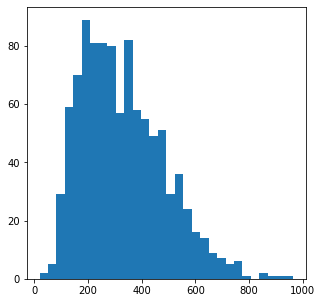

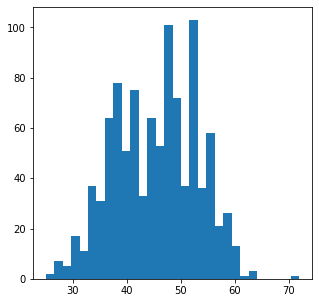

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

article_word_count = []
summary_word_count = []

for sentences in clean_article_train['article']:
  article_word_count.append(len(sentences.split()))

for sentences in clean_summary_train['summary']:
  summary_word_count.append(len(sentences.split()))


Length_df = pd.DataFrame({'article': article_word_count, 'summary': summary_word_count})

plt.figure(figsize=(5, 5))
plt.hist(Length_df['article'], bins=30)

plt.figure(figsize=(5, 5))
plt.hist(Length_df['summary'], bins=30)


plt.show();

In [96]:
max_len_article = 400
max_len_summary = 55

**Article Tokenizing**

In [97]:
article_tokenizer = Tokenizer()

article_tokenizer.fit_on_texts(list(clean_article_train['article']))

article_train_data = article_tokenizer.texts_to_sequences(clean_article_train['article'])
article_test_data = article_tokenizer.texts_to_sequences(clean_article_test['article'])

article_train_data = pad_sequences(article_train_data, maxlen=max_len_article, padding='post')
article_test_data = pad_sequences(article_test_data, maxlen=max_len_article, padding='post')

article_vocab_size = len(article_tokenizer.word_index) + 1

**Summary Tokenizing**

In [98]:
summary_tokenizer = Tokenizer()

summary_tokenizer.fit_on_texts(list(clean_summary_train['summary']))

summary_train_data = summary_tokenizer.texts_to_sequences(clean_summary_train['summary'])
summary_test_data = summary_tokenizer.texts_to_sequences(clean_summary_test['summary'])

summary_train_data = pad_sequences(summary_train_data, maxlen=max_len_summary, padding='post')
summary_test_data = pad_sequences(summary_test_data, maxlen=max_len_summary, padding='post')

summary_vocab_size = len(summary_tokenizer.word_index) + 1

**Model Creation**

In [99]:
from keras import backend as K
K.clear_session()
output_dim_article = 800
output_dim_summary = 100

**Encoder System**

In [1]:
# Input Layer
encoder_inputs = Input(shape=(max_len_article,))
encoder_embedding = Embedding(article_vocab_size, output_dim_article, trainable=True)(encoder_inputs)

# First Layer
encoder_lstm1 = Bidirectional(LSTM(output_dim_article, return_sequences=True, return_state=True, dropout=0.25))
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

# Second Layer
encoder_lstm2 = Bidirectional(LSTM(output_dim_article, return_sequences=True, return_state=True, dropout=0.25))
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# Third Layer
encoder_lstm3 = Bidirectional(LSTM(output_dim_article, return_sequences=True, return_state=True, dropout=0.25))
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

NameError: ignored

**Decoder System**

In [107]:
# Input Layer
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(summary_vocab_size, output_dim_summary, trainable=True)(decoder_inputs) 

# First Layer
decoder_lstm1 = Bidirectional(LSTM(output_dim_summary, return_sequences=True, return_state=True))
decoder_output1, state_h1, state_c1 = decoder_lstm1(decoder_embedding, initial_state=[state_h3, state_c3])

NameError: ignored

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Attention Layer**

In [ ]:
Attention_layer = Attention(dropout=0.3)
Attention_output, Attention_states = Attention_layer([encoder_output3, decoder_output1])

**Decoder Final Layers**

In [ ]:
# Concatenate attention output and decoder output
concat_output = Concatenate(axis=-1, name='concat_layer')([decoder_output1, Attention_output]) 

# Dense Layer
decoder_dense = TimeDistributed(Dense(summary_vocab_size, activation='softmax'))
decoder_output = decoder_dense(concat_output)

**Define Model**

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_output)
model.summary()

**Compile Model, Fit, and Visualize**

In [ ]:
# Compile
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

# Fit
history = model.fit([article_train_data, summary_train_data[:,:-1]],\
                    summary_train_data.reshape(summary_train_data.shape[0], summary_train_data.shape[1], 1)[:,1:], epochs=50, callbacks=[es], batch_size=500,\
                    validation_data([article_test_data, summary_test_data[:,:-1]], summary_test_data.reshape(summary_test_data.shape[0], summary_test_data.shape[1], 1)[:,1:]))

# Visualize
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show();